In [130]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import skewnorm

In [61]:
def load_csv(dur):
    with open(f"../analysis/runner_{dur}sec.csv", newline='') as csvfile:
        benchreader = csv.reader(csvfile, delimiter=",")
        
        headings = next(benchreader) 

        run_dict = {
            f"runs_{dur}sec_mean": [],
            f"runs_{dur}sec_stddev": [],
            f"runs_{dur}sec_median": [],
            f"runs_{dur}sec_min": [],
            f"runs_{dur}sec_max": []
        }
        
        batches = 19
        correctur_value = dur*batches
        
        for row in benchreader:
            run_dict[f"runs_{dur}sec_mean"].append(float(row[1]) - correctur_value)
            run_dict[f"runs_{dur}sec_stddev"].append(float(row[2]))
            run_dict[f"runs_{dur}sec_median"].append(float(row[3]) - correctur_value)
            run_dict[f"runs_{dur}sec_min"].append(float(row[6]) - correctur_value)
            run_dict[f"runs_{dur}sec_max"].append(float(row[7]) - correctur_value)
        
        run_dict[f"runs_{dur}sec_mean"] = np.array(run_dict[f"runs_{dur}sec_mean"])
        run_dict[f"runs_{dur}sec_stddev"] = np.array(run_dict[f"runs_{dur}sec_stddev"])
        run_dict[f"runs_{dur}sec_median"] = np.array(run_dict[f"runs_{dur}sec_median"])
        run_dict[f"runs_{dur}sec_min"] = np.array(run_dict[f"runs_{dur}sec_min"])
        run_dict[f"runs_{dur}sec_max"] = np.array(run_dict[f"runs_{dur}sec_max"])
        
    return headings, run_dict

In [62]:
runs_per_epoch = 19

num_worker = np.array(range(2,20,2))
print(num_worker)

[ 2  4  6  8 10 12 14 16 18]


In [ ]:
h, runs_0sec = load_csv(0)
h, runs_1sec = load_csv(1)
h, runs_2sec = load_csv(2)
h, runs_5sec = load_csv(5)

# Comparison of Train Time for Dataloader Worker

The dataloader includes an argument `num_worker` which allows multiple processes to load data.
Depending of the time consumpted by the training process the dataloading process could vary, based on `num_worker`.
This Analysis shows the results of four different Benchmarks, which are generated with `hyperbench`, a high performance benchmarktool written in rust[1].

[1]: [hyperfine](https://github.com/sharkdp/hyperfine)

Text(0.5, 1.0, 'Worker Time Consumption based on Train Time')

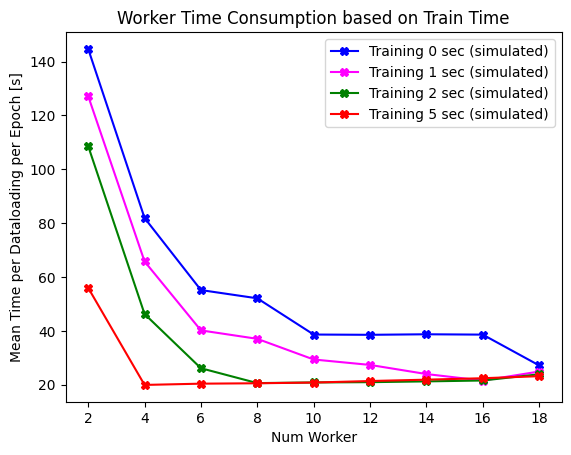

In [78]:
plt.plot(num_worker, runs_0sec["runs_0sec_mean"], marker="X", color="blue")
plt.plot(num_worker, runs_1sec["runs_1sec_mean"], marker="X", color="magenta")
plt.plot(num_worker, runs_2sec["runs_2sec_mean"], marker="X", color="green")
plt.plot(num_worker, runs_5sec["runs_5sec_mean"], marker="X", color="red")
plt.xlabel("Num Worker")
plt.ylabel("Mean Time per Dataloading per Epoch [s]")
plt.legend([
    "Training 0 sec (simulated)",
    "Training 1 sec (simulated)",
    "Training 2 sec (simulated)",
    "Training 5 sec (simulated)"
])
plt.title("Worker Time Consumption based on Train Time")

Text(0.5, 1.0, 'Worker Time Consumption based on Train Time with errors')

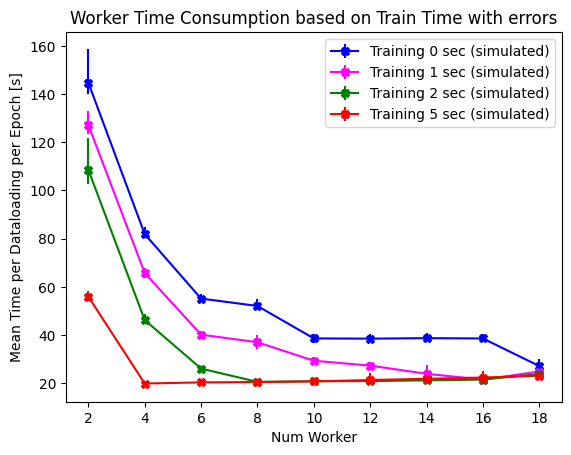

In [80]:
plt.errorbar(
    num_worker, runs_0sec["runs_0sec_mean"],
    [
        runs_0sec["runs_0sec_mean"] -  runs_0sec["runs_0sec_min"],
        runs_0sec["runs_0sec_max"]-  runs_0sec["runs_0sec_mean"]
    ], marker="X", color="blue"
)
plt.errorbar(
    num_worker, runs_1sec["runs_1sec_mean"],
    [
        runs_1sec["runs_1sec_mean"] -  runs_1sec["runs_1sec_min"],
        runs_1sec["runs_1sec_max"]-  runs_1sec["runs_1sec_mean"]
    ], marker="X", color="magenta"
)
plt.errorbar(
    num_worker, runs_2sec["runs_2sec_mean"],
    [
        runs_2sec["runs_2sec_mean"] -  runs_2sec["runs_2sec_min"],
        runs_2sec["runs_2sec_max"]-  runs_2sec["runs_2sec_mean"]
    ], marker="X", color="green"
)
plt.errorbar(
    num_worker, runs_5sec["runs_5sec_mean"],
    [
        runs_5sec["runs_5sec_mean"] -  runs_5sec["runs_5sec_min"],
        runs_5sec["runs_5sec_max"]-  runs_5sec["runs_5sec_mean"]
    ], marker="X", color="red")
plt.xlabel("Num Worker")
plt.ylabel("Mean Time per Dataloading per Epoch [s]")
plt.legend([
    "Training 0 sec (simulated)",
    "Training 1 sec (simulated)",
    "Training 2 sec (simulated)",
    "Training 5 sec (simulated)"
])
plt.title("Worker Time Consumption based on Train Time with errors")

# Mean results

The values of the benchmark are corrected by the amount of the simulated training.
The simulated training time is simulated by a simple `sleep(duration)`.
The graph shows that with rising training time consumption the number of necessary workers is reduced.
If the training tooks 0 seconds the amount of necessary workers isn't reached with 18 workers.
This scenario is very unlikly.
With the training tooks 5 seconds it is shown, that already 4 worker  satisfy a minimum value, which only rises with rising number of workers.
With 2 seconds the sweetspot is reached at 8 Workers and with 1 second at 16 Workers.
Based on this small analysis we can formulate perfect value of `num_worker`:

For every halfing of training time we estimate a double of necessary worker.

Text(0.5, 1.0, 'Worker Time Consumption based on Train Time')

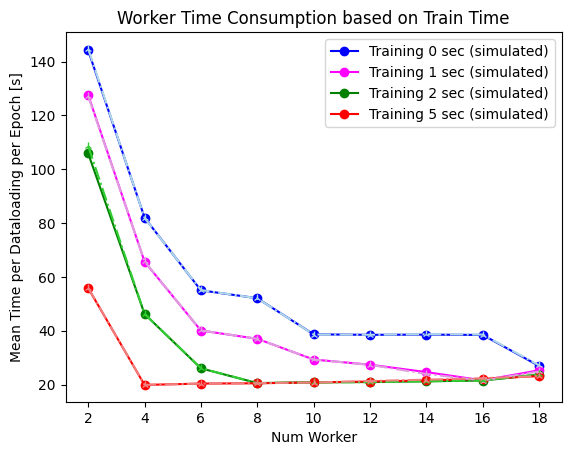

In [99]:
plt.plot(num_worker, runs_0sec["runs_0sec_median"], marker="o", color="blue")
plt.plot(num_worker, runs_1sec["runs_1sec_median"], marker="o", color="magenta")
plt.plot(num_worker, runs_2sec["runs_2sec_median"], marker="o", color="green")
plt.plot(num_worker, runs_5sec["runs_5sec_median"], marker="o", color="red")
plt.plot(num_worker, runs_0sec["runs_0sec_mean"], marker="2", color="lightblue", linestyle="dashdot")
plt.plot(num_worker, runs_1sec["runs_1sec_mean"], marker="2", color="plum", linestyle="dashdot")
plt.plot(num_worker, runs_2sec["runs_2sec_mean"], marker="2", color="limegreen", linestyle="dashdot")
plt.plot(num_worker, runs_5sec["runs_5sec_mean"], marker="2", color="lightcoral", linestyle="dashdot")
plt.xlabel("Num Worker")
plt.ylabel("Mean Time per Dataloading per Epoch [s]")
plt.legend([
    "Training 0 sec (simulated)",
    "Training 1 sec (simulated)",
    "Training 2 sec (simulated)",
    "Training 5 sec (simulated)"
])
plt.title("Worker Time Consumption based on Train Time")

In [101]:
diff_0 = np.abs(["runs_0sec_mediruns_0secan"] -runs_0sec["runs_0sec_mean"])
diff_1 = np.abs(runs_1sec["runs_1sec_median"] -runs_1sec["runs_1sec_mean"])
diff_2 = np.abs(runs_2sec["runs_2sec_median"] -runs_2sec["runs_2sec_mean"])
diff_5 = np.abs(runs_5sec["runs_5sec_median"] -runs_5sec["runs_5sec_mean"])

print("Diff 0: ", diff_0)
print("Diff 1: ", diff_1)
print("Diff 2: ", diff_2)
print("Diff 5: ", diff_5)

Diff 0:  [0.54067984 0.10452255 0.10901598 0.01925771 0.05505795 0.01526781
 0.13578732 0.13124994 0.22742934]
Diff 1:  [0.37669232 0.10496912 0.05799504 0.00781922 0.02751401 0.06400062
 0.70115716 0.07193544 0.46011023]
Diff 2:  [2.73513545 0.00438287 0.05523651 0.00441082 0.03340314 0.02436414
 0.02398003 0.02706973 0.15087538]
Diff 5:  [0.11058646 0.0141455  0.01660716 0.01541808 0.0492998  0.21147907
 0.29678592 0.24065909 0.02271482]


Further, we analyzed the absolute difference between mean and median and could only notice a difference above one second for the 2 second run.
By this statement we assume that we are handling mostly skewed normal distributions.

In [126]:
def calc_skew(run_dict, dur):
    xi = np.array([
        run_dict[f"runs_{dur}sec_median"],
        run_dict[f"runs_{dur}sec_min"],
        run_dict[f"runs_{dur}sec_max"]
    ]) 
    mu = run_dict[f"runs_{dur}sec_mean"]
    sig = run_dict[f"runs_{dur}sec_stddev"]
    return np.sum(np.power((xi - mu) / sig, 3),0)

In [128]:
skew_0sec = calc_skew(runs_0sec, 0)
skew_1sec = calc_skew(runs_1sec, 1)
skew_2sec = calc_skew(runs_2sec, 2)
skew_5sec = calc_skew(runs_5sec, 5)

In [166]:
alpha0 = skew_0sec[0]
mu0 = runs_0sec["runs_0sec_mean"][0]
sigma0 = runs_0sec["runs_0sec_stddev"][0]

y0 = skewnorm.rvs(alpha0, mu0, sigma0, size=10000)

In [167]:
alpha1 = skew_1sec[0]
mu1 = runs_1sec["runs_1sec_mean"][0]
sigma1 = runs_1sec["runs_1sec_stddev"][0]

y1 = skewnorm.rvs(alpha1, mu1, sigma1, size=10000)

In [168]:
alpha2 = skew_2sec[0]
mu2 = runs_2sec["runs_2sec_mean"][0]
sigma2 = runs_2sec["runs_2sec_stddev"][0]

y2 = skewnorm.rvs(alpha2, mu2, sigma2, size=10000)

In [169]:
alpha5 = skew_5sec[0]
mu5 = runs_5sec["runs_5sec_mean"][0]
sigma5 = runs_5sec["runs_5sec_stddev"][0]

y5 = skewnorm.rvs(alpha5, mu5, sigma5, size=10000)

Text(0.5, 1.0, 'Skew normal distribution')

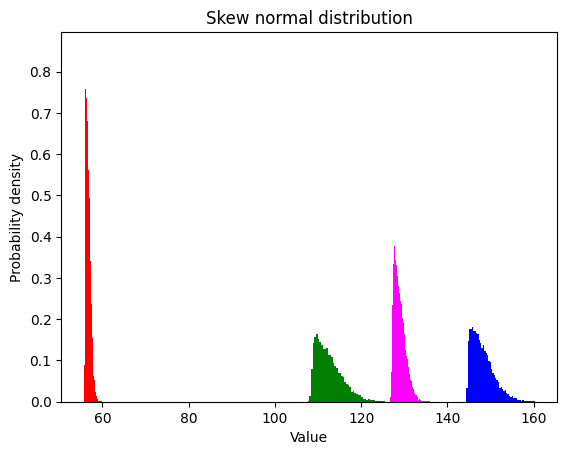

In [170]:
plt.hist(y0, bins=50, density=True, color="blue")
plt.hist(y1, bins=50, density=True, color="magenta")
plt.hist(y2, bins=50, density=True, color="green")
plt.hist(y5, bins=50, density=True, color="red")
plt.xlabel('Value')
plt.ylabel('Probability density')
plt.title('Skew normal distribution')